## Programming Assignment 1B. 
###### Mihkel Sildnik &  Julio Ponte        

## Task 1:

### Step 1: Reading the data

In [69]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot

In [70]:
traindf = pd.read_csv("adult_train.csv")
testdf = pd.read_csv("adult_test.csv")

Xtrain = traindf.drop('target', axis = 'columns')
Ytrain = traindf['target']

Xtest = testdf.drop('target', axis = 'columns')
Ytest = testdf['target']

#Extra modifications:

Ytrain = Ytrain.apply(lambda x: x == '>50K')
Ytest = Ytest.apply(lambda x: x == '>50K')


### Step 2: Encoding features as numbers

In [73]:
Xtrain_dicts = Xtrain.to_dict('records')
Xtest_dicts = Xtest.to_dict('records')
dict_vectorizer = DictVectorizer()

Xtrain_encoded = dict_vectorizer.fit_transform(Xtrain_dicts)
Xtest_encoded = dict_vectorizer.transform(Xtest_dicts)

In [74]:
gbc = GradientBoostingClassifier()
gbc.fit(Xtrain_encoded, Ytrain)
Yguess = gbc.predict(Xtest_encoded)
mean_score = np.mean(cross_val_score(gbc, Xtrain_encoded, Ytrain, cv=5))
print(mean_score, accuracy_score(Ytest, Yguess))

0.8659132924851489 0.8712609790553406


Using a Gradient Boosting Classifier we got a mean cross validation score of 0.866 and an accuracy score of 0.871 on
the test set.

### Step 3: Combining the steps

In [77]:
Pipeline = make_pipeline(DictVectorizer(), GradientBoostingClassifier())
Pipeline.fit(Xtrain_dicts,Ytrain)
Yguess = Pipeline.predict(Xtest_dicts)
pipeline_accuracy = accuracy_score(Ytest, Yguess)
print("GradientBosstingClassifier PIPELINE accuracy_score: ", pipeline_accuracy)

GradientBosstingClassifier PIPELINE accuracy_score:  0.8712609790553406


## Task 2: Decision trees and random forests

#### Underfitting & overfitting Decision Tree clf:

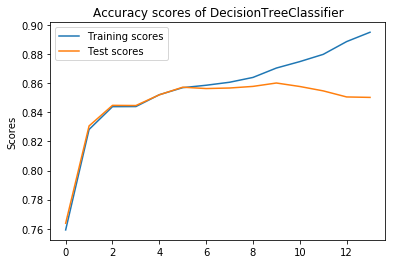

In [76]:
trainingscores_dtree = list()
testingscores_dtree = list()

for depth in range(1, 15):
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(Xtrain_encoded, Ytrain)
    YguessTrain_dtree = clf.predict(Xtrain_encoded)
    YguessTest_dtree = clf.predict(Xtest_encoded)
    trainingscores_dtree.append(accuracy_score(Ytrain, YguessTrain_dtree))
    testingscores_dtree.append(accuracy_score(Ytest, YguessTest_dtree))
    
x_axis = [x for x in range(14)]
pyplot.title('Accuracy scores of DecisionTreeClassifier')
pyplot.ylabel('Scores')
pyplot.plot(x_axis, trainingscores_dtree)
pyplot.plot(x_axis, testingscores_dtree)
pyplot.legend(['Training scores', 'Test scores'], loc = 'upper left')

From the graph above, we can identify where the model starts to overfit the data. (around a value of 8 for the max_depth parameter of the classifier)

#### Underfitting and overfitting Random forest clf

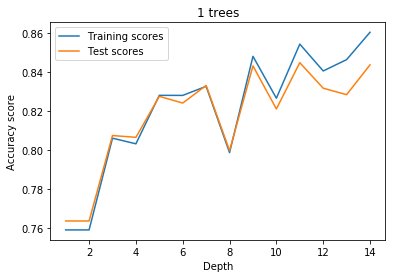

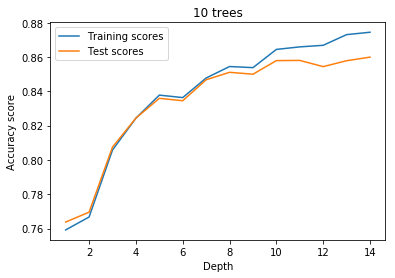

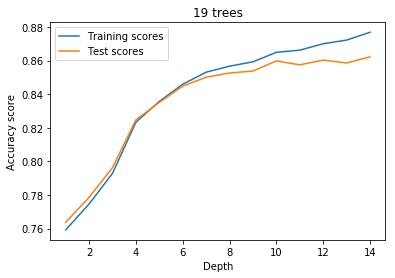

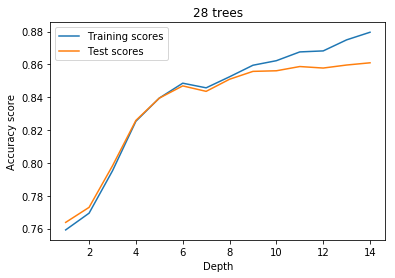

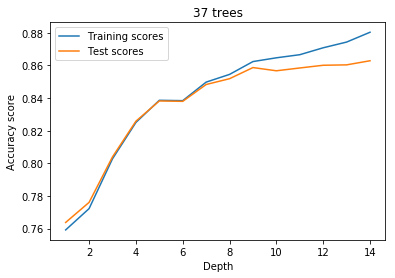

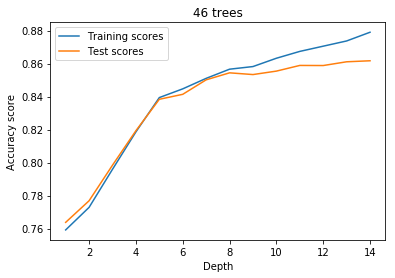

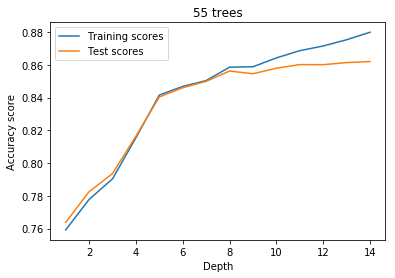

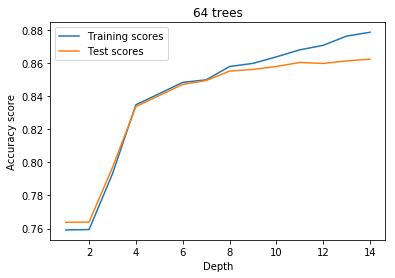

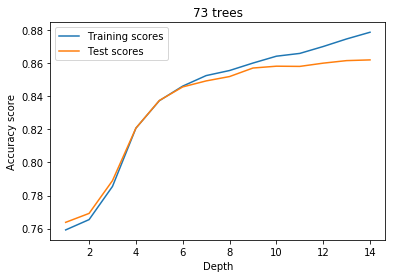

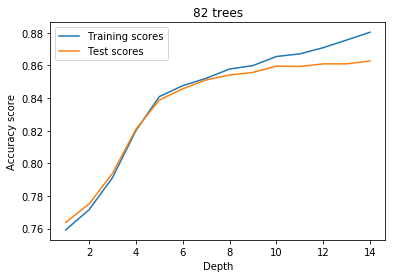

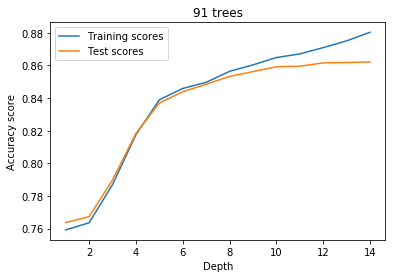

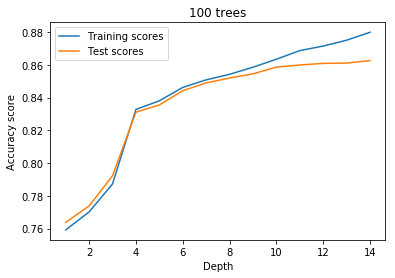

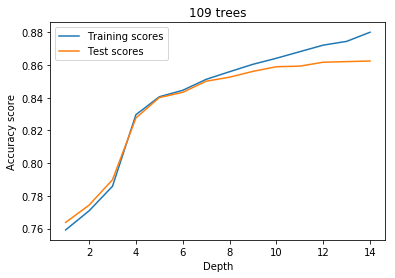

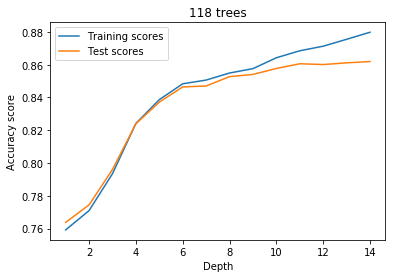

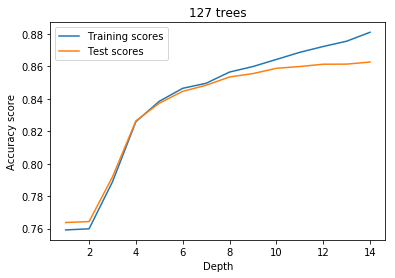

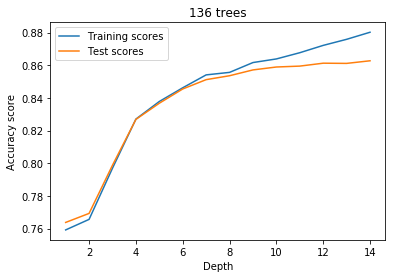

In [ ]:
def plot_test_train_trees(max_depth, trees, Xtrain, Ytrain, Xtest, Ytest):
    training_scores = []
    test_scores = []
    for depth in range(1, max_depth):
       tree_reg = RandomForestClassifier(n_estimators=trees, n_jobs=-1, max_depth=depth)
       tree_reg.fit(Xtrain, Ytrain)
       Ypredict_test = tree_reg.predict(Xtest)
       Ypredict_train = tree_reg.predict(Xtrain)
       training_scores.append(accuracy_score(Ytrain, Ypredict_train))
       test_scores.append(accuracy_score(Ytest, Ypredict_test))
    x_axis = [x for x in range(1, max_depth)]
    pyplot.plot(x_axis, training_scores)
    pyplot.plot(x_axis, test_scores)
    pyplot.ylabel('Accuracy score')
    pyplot.xlabel("Depth")
    pyplot.title(str(trees)+" trees")
    pyplot.legend(['Training scores', 'Test scores'], loc = 'upper left')
    pyplot.show()

for trees in range(1, 150, 9):
    plot_test_train_trees(15, trees, Xtrain_encoded, Ytrain, Xtest_encoded, Ytest)

###### What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?
The difference between the curves is that the random forest with one tree suffers far less from overfitting the model.
While overfitting still happens it is not as drastic and also the curve is a lot less smooth. This is because random forest 
trains the individual tree on a bootstrapped sample and also randomly picks features. 

###### What happens with the curve for random forests as the ensemble size grows?
As the ensemble size grows the overfitting seems to lessen although this effect has diminishing returns.

###### What happens with the best observed test set accuracy as the ensemble size grows?
We were not sure what was meant by this but we logged the best test set accuracy for the different values of max_depth and
found that after an initial uptick the value quickly reaches a ceiling, mostly staying around the same value without much variation.

###### What happens with the training time as the ensemble size grows?
The training time grows linearly, although it does this in chunks, since it uses all cores then adding 
one tree after all cores are used once doubles the time but adding one more barely changes things since cores will be free.
So the training time is something like: some constant times the number of trees divided by the cores available. (rounded up)

### Task 3: Feature importances in random forest classifiers

In [80]:
rfclf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_leaf=10, max_depth = 7)
rfclf.fit(Xtrain_encoded, Ytrain)
importances = rfclf.feature_importances_
std_dev = np.std([tree.feature_importances_ for tree in rfclf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [81]:
print("5 most important features: \n")
for i in range(Xtrain.shape[1])[:5]:
    print( "%d. %s (%f) " % (i+1, dict_vectorizer.feature_names_[indices[i]], importances[indices[i]]))

5 most important features: 

1. relationship=Husband (0.165675) 
2. capital-gain (0.143739) 
3. marital-status=Married-civ-spouse (0.115562) 
4. education-num (0.111926) 
5. marital-status=Never-married (0.062349) 


The five most "important" features are in descending order:
Married-Civ_spouse, capital-gain, education-num, if they are a husband, and finally if they were never married.

In addition to feature: Husband, we see that there are two additional features that pertain to a persons marital status. This would suggest that a persons marital status is an important factor in trying to predict their bracket of income. Perhaps the fact that If a person is married, means that they have to spend time living together, so less time for working extra hours, and also less time to invest into pursuing promotions. Capital gain shows the profit made from selling a capital asset. Being in a position to own an asset such as this is a good indicator of economic well being as well as the fact that capital gain post-tax is also part of income. 

Education-num shows the highest level of education achieved by a person. This is very logical as a persons education plays a large role in the jobs they can get and also the level of pay they recieve. Generally the higher the education the higher the pay. At the very least a low education will almost always mean a lower income. Being a husband would be beneficial because generally men make more as well as the fact that most people who can afford a wedding or to get married have the free funds to do so.

One flaw in this dataset in my opinion is that we have very little knowledge about the location
of the person. A large part of income is dependant on where people live. The salaries on coasts and larger metropolises 
are a lot higher than in rural parts for the same jobs. This introduces substantial noise in my opinion.

###### Alternative to calculate the importance of features

An alternative way to compute importance of features is to use permutation importance as talked about in the link provided (https://explained.ai/rf-importance/)
We get the permutation importance of a feature by logging the accuracy with a validation set, then we permutate the values
of the feature column in question and recalculate the accuracy. The difference in these scores is the permutation importance.
It is obvious that a feature is not important if changing the permutation of the column has a negligible efect on the accuracy.